## Importing Required Libraries

In [1]:
!pip install nlpaug
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
clear_output()
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno #For missing value visualization

import plotly.offline as py
py.init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import time
#For NLP
import re
import nltk
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
#For Calculation of Performance of Models
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
#For Modelling Purpose
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
nltk.download('omw-1.4')
clear_output()

## Data Exploration

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import quote_plus
import time

# Load dataset
# df = pd.read_csv("/kaggle/input/book-metadata-from-bookstoscrape/dataset.csv", quotechar='"', encoding='utf-8', on_bad_lines='skip', header=None)
df = pd.read_csv("/kaggle/input/booksdata/books_data.csv")
df.head()

,Title,Price,Availability,Rating,Link,Thumbnail URL,Thumbnail File Name,Description,Genre
0,A Light in the Attic,£51.77,In stock,3,https://books.toscrape.com/catalogue/a-light-i...,https://books.toscrape.com/../media/cache/2c/d...,images\A_Light_in_the_Attic.jpg,It's hard to imagine a world without A Light i...,Poetry
1,Tipping the Velvet,£53.74,In stock,1,https://books.toscrape.com/catalogue/tipping-t...,https://books.toscrape.com/../media/cache/26/0...,images\Tipping_the_Velvet.jpg,"""Erotic and absorbing...Written with starling ...",Historical Fiction
2,Soumission,£50.10,In stock,1,https://books.toscrape.com/catalogue/soumissio...,https://books.toscrape.com/../media/cache/3e/e...,images\Soumission.jpg,"Dans une France assez proche de la nôtre, un h...",Fiction
3,Sharp Objects,£47.82,In stock,4,https://books.toscrape.com/catalogue/sharp-obj...,https://books.toscrape.com/../media/cache/32/5...,images\Sharp_Objects.jpg,"WICKED above her hipbone, GIRL across her hear...",Mystery
4,Sapiens: A Brief History of Humankind,£54.23,In stock,5,https://books.toscrape.com/catalogue/sapiens-a...,https://books.toscrape.com/../media/cache/be/a...,images\Sapiens__A_Brief_History_of_Humankind.jpg,From a renowned historian comes a groundbreaki...,History


In [3]:
print('Original Data Size: ', df.shape)
print('Genre Count: ', df.Genre.value_counts())

Original Data Size:  (1000, 9)
Genre Count:  Genre
Default               152
Nonfiction            110
Sequential Art         75
Add a comment          67
Fiction                65
Young Adult            54
Fantasy                48
Romance                35
Mystery                32
Food and Drink         30
Childrens              29
Historical Fiction     26
Poetry                 19
Classics               19
History                18
Horror                 17
Womens Fiction         17
Science Fiction        16
Science                14
Music                  13
Business               12
Travel                 11
Philosophy             11
Thriller               11
Humor                  10
Autobiography           9
Art                     8
Psychology              7
Religion                7
Spirituality            6
Christian Fiction       6
New Adult               6
Sports and Games        5
Self Help               5
Biography               5
Health                  4
Politics     

In [4]:
df.columns

Index(['Title', 'Price', 'Availability', 'Rating', 'Link', 'Thumbnail URL',
       'Thumbnail File Name', 'Description', 'Genre'],
      dtype='object')

In [5]:
non_string_count = df['Description'].apply(lambda x: not isinstance(x, str)).sum()
print(f"Non-string values in Description: {non_string_count}")

Non-string values in Description: 2


## Data Cleaning

In [6]:
#cleaning unecessary text from the string 
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Stopwords = set(stopwords.words('english'))

def clean(text):
    if not isinstance(text, str):  # Check if input is a string
        return ""
    
    text = text.lower()  # Lowercase
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)  # Remove punctuation

    text_tokens = word_tokenize(text)  # Tokenize
    tw = [word for word in text_tokens if word not in Stopwords]  # Remove stopwords
    text = " ".join(tw)

    splt = text.split(' ')
    output = [x for x in splt if len(x) > 3]  # Remove short words
    text = " ".join(output)

    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)  # Remove single characters
    text = re.sub('<.*?>+', ' ', text)  # Remove HTML tags
    text = re.sub('\n', ' ', text)  # Remove newlines
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace

    return text

df['Description'] = df['Description'].apply(clean)

In [7]:
genre_counts = df['Genre'].value_counts()
top_genres = genre_counts[genre_counts >= 40].index.tolist()  # Keep genres with ≥9 examples
# Filter dataset
df = df[df['Genre'].isin(top_genres)].copy()
# Optional: Balance the dataset by undersampling majority genres
# min_size = df_top['Genre'].value_counts().min()
# df_balanced = df_top.groupby('Genre').sample(n=min_size, random_state=42)

print("Balanced dataset shape:", df.shape)
print(df['Genre'].value_counts())

Balanced dataset shape: (571, 9)
Genre
Default           152
Nonfiction        110
Sequential Art     75
Add a comment      67
Fiction            65
Young Adult        54
Fantasy            48
Name: count, dtype: int64


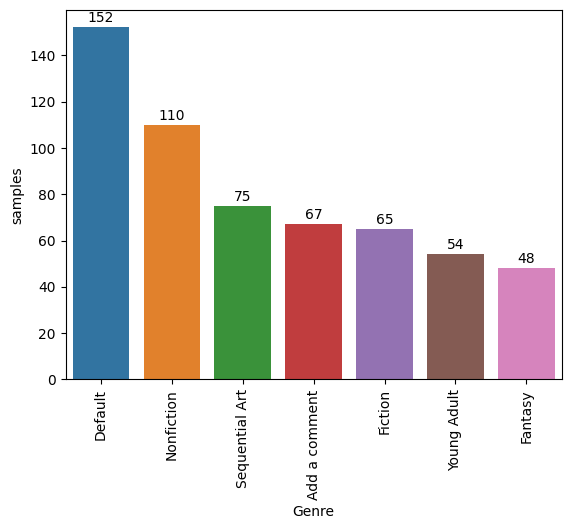

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

x = df['Genre'].value_counts()
ax = sns.barplot(x=x.index, y=x.values)
plt.gca().set_ylabel('samples')
plt.xticks(rotation=90)  # Rotate x-axis labels

# Add count labels on top of bars
for i, v in enumerate(x.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

## Data Augmentation

In [9]:
import torch
print("Is CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else "No GPU")
!nvidia-smi

Is CUDA available: True
Current device: 0
Device name: Tesla P100-PCIE-16GB
Sun Jun 15 19:51:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             28W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                     

In [10]:
import nlpaug.augmenter.word as naw
from tqdm import tqdm
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import torch

# Set up augmentation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

aug_w2v = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased',
    action='substitute',
    device=device  # explicitly set device to 'cuda'
)


# Function to augment underrepresented class
def augment_text(df, target_genre, label_column='Genre', text_column='Description', samples=100, aug_prob=0.2):
    aug_w2v.aug_p = aug_prob
    new_texts = []

    # Filter the target class
    df_minority = df[df[label_column] == target_genre].reset_index(drop=True)
    
    if len(df_minority) == 0:
        print(f"[Warning] No samples found for genre: {target_genre}. Skipping augmentation.")
        return df

    for i in tqdm(np.random.randint(0, len(df_minority), samples)):
        text = df_minority.loc[i, text_column]
        try:
            augmented = aug_w2v.augment(text)
            if isinstance(augmented, list):
                augmented = " ".join(augmented)  # join if list
            new_texts.append((augmented, target_genre))
        except Exception as e:
            print(f"[Skip] Error augmenting row {i}: {e}")
            continue

    # Create new rows as DataFrame
    df_aug = pd.DataFrame(new_texts, columns=[text_column, label_column])
    return shuffle(pd.concat([df, df_aug], ignore_index=True))

# Augment only underrepresented genres
df = augment_text(df, target_genre='Nonfiction', samples=42)
df = augment_text(df, target_genre='Sequential Art', samples=77)
df = augment_text(df, target_genre='Add a comment', samples=85)
df = augment_text(df, target_genre='Fiction', samples=87)
df = augment_text(df, target_genre='Young Adult', samples=98)
df = augment_text(df, target_genre='Fantasy', samples=104)

2025-06-15 19:52:07.649007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750017127.830618      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750017127.883936      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 104/104 [00:13<00:00,  7.44it/s]


Genre
Nonfiction        152
Young Adult       152
Default           152
Add a comment     152
Fantasy           152
Fiction           152
Sequential Art    152
Name: count, dtype: int64


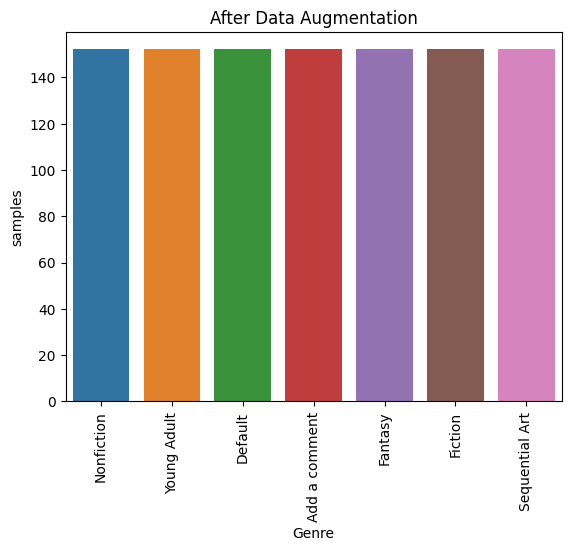

In [11]:
print(df['Genre'].value_counts())
x = df['Genre'].value_counts()
sns.barplot(x=x.index, y=x.values)
plt.gca().set_ylabel('samples')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.title('After Data Augmentation')
plt.show()

In [12]:
print('Augmented Data Size: ', df.shape)

Augmented Data Size:  (1064, 9)


## Data Visualization

Default


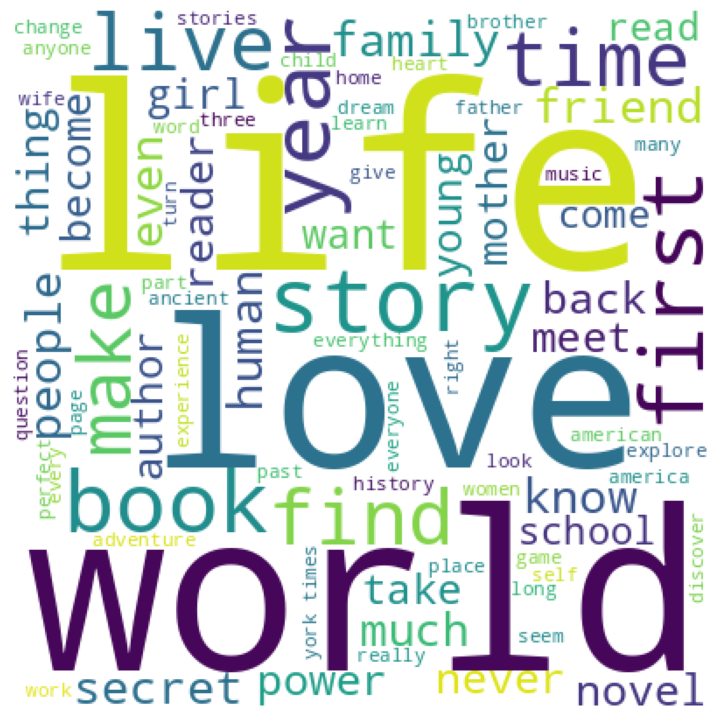

Nonfiction


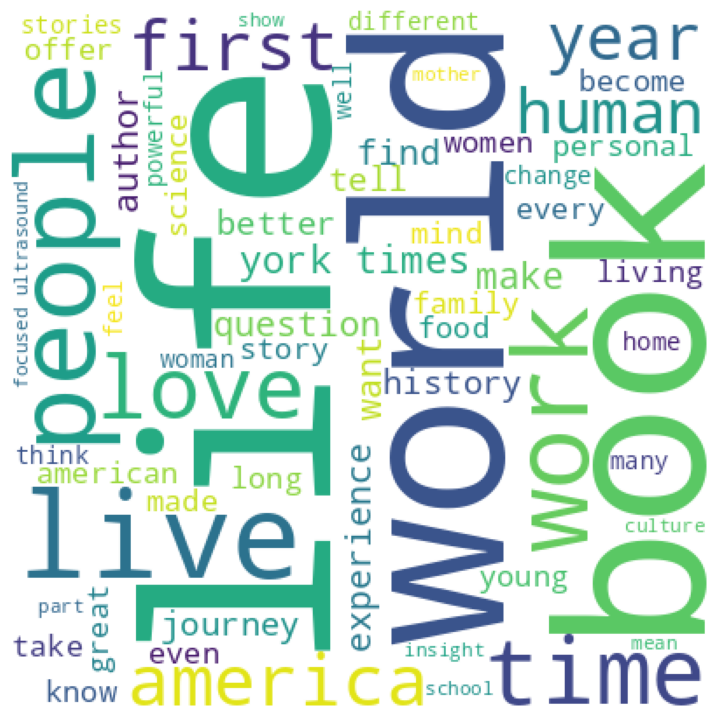

Sequential Art


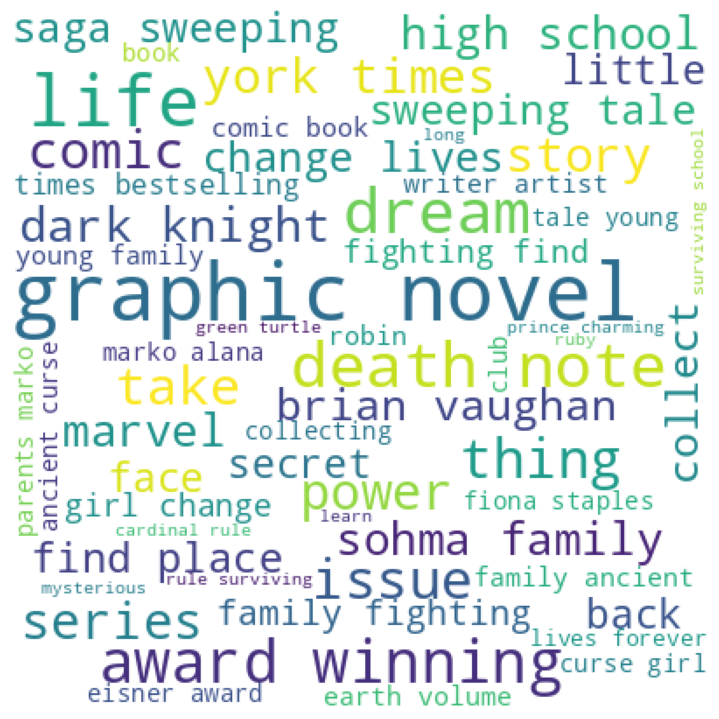

Add a comment


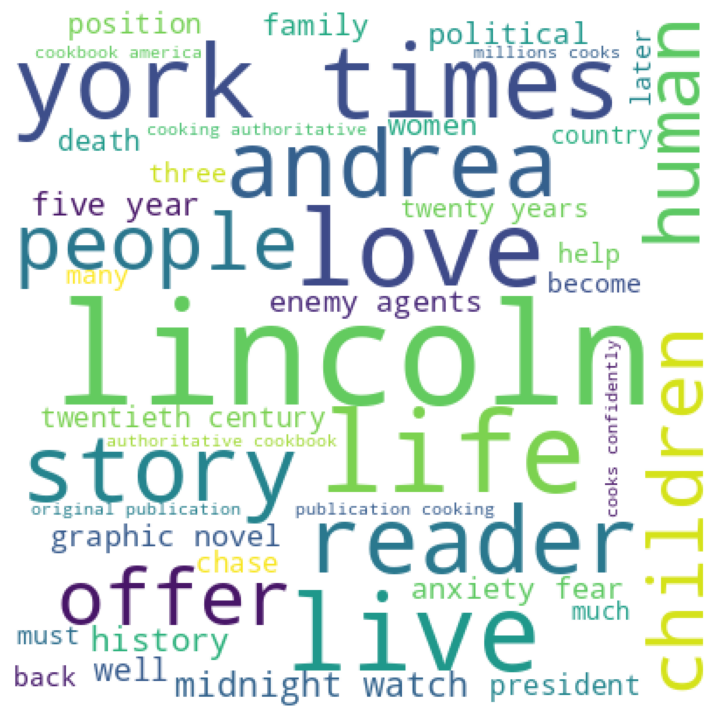

Fiction


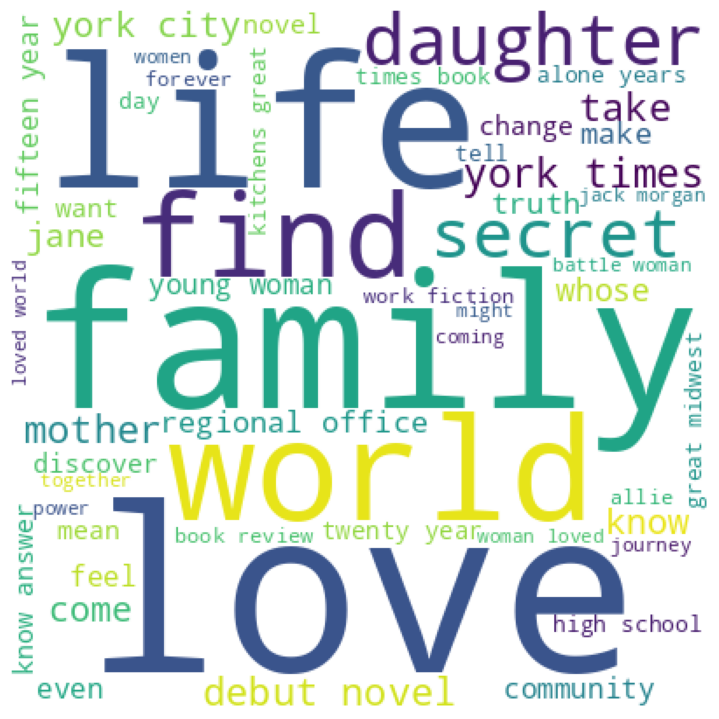

Young Adult


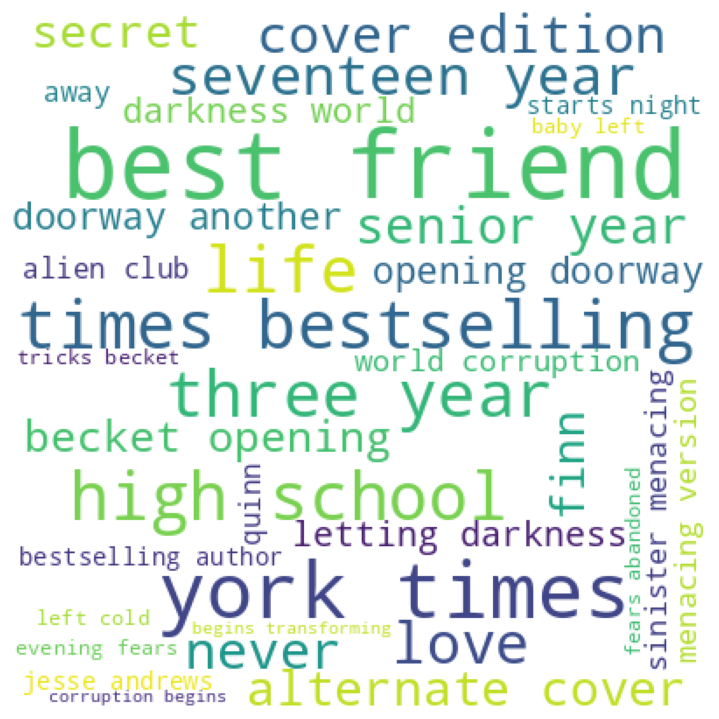

Fantasy


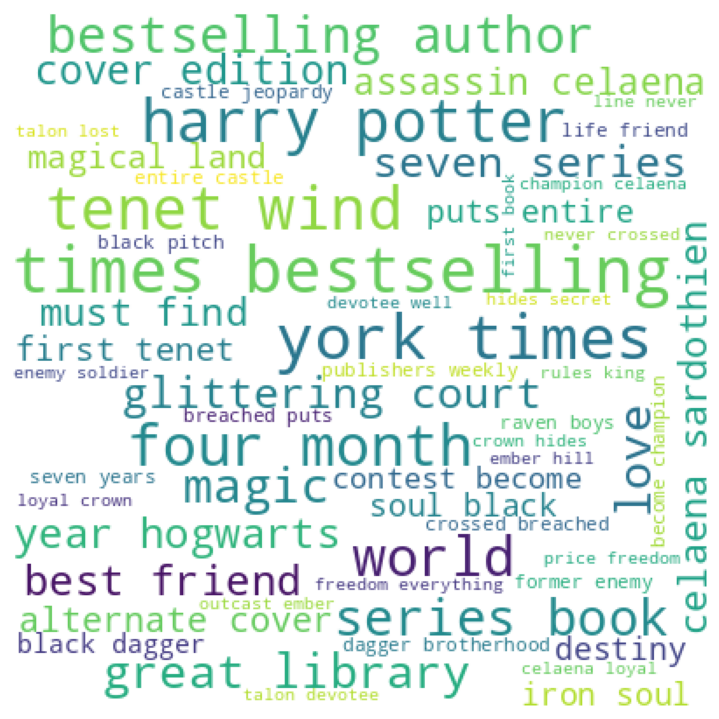

In [13]:
def print_wordCloud(genre,summary):
    print(genre)
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                min_font_size = 10).generate(summary)
    plt.figure(figsize = (7, 7), facecolor = 'white', edgecolor='blue') 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()
def make_string(genre):
    s = ""
    for row_index,row in df.iterrows():
        if(row['Genre'] == genre):
            s+=(row['Description']+' ')
    return s

genre = ['Default','Nonfiction','Sequential Art','Add a comment','Fiction','Young Adult','Fantasy']
for Genre in genre:
    summary = make_string(Genre)
    print_wordCloud(Genre,summary)

In [14]:
def data_preprocessing(text):
    tokens = word_tokenize(text) #Tokenization
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens] #Lemmetization
    tokens = [SnowballStemmer(language = 'english').stem(word) for word in tokens] #Stemming
    return " ".join(tokens)

In [15]:
df['Description'] = df['Description'].apply(data_preprocessing)
df['Title'] = df['Title'].apply(data_preprocessing)
df

TypeError: expected string or bytes-like object, got 'float'

## Modelling and Training

In [13]:
le = LabelEncoder()
df['Genre'] = le.fit_transform(df['Genre'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)

{'Add a comment': 0, 'Default': 1, 'Fantasy': 2, 'Fiction': 3, 'Nonfiction': 4, 'Sequential Art': 5, 'Young Adult': 6}


In [14]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Description'])
y = df['Genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

models = [BernoulliNB(),MultinomialNB(),SGDClassifier(),LogisticRegression(),RandomForestClassifier(),GradientBoostingClassifier(),
         AdaBoostClassifier(),SVC(),DummyClassifier(),ExtraTreeClassifier(),KNeighborsClassifier()]

In [15]:
Name = []
Accuracy = []
Precision = []
F1_Score = []
Recall = []
Time_Taken = []
for model in models:
    name = type(model).__name__
    Name.append(name)
    model = OneVsRestClassifier(model)
    begin = time.time()
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    end = time.time()
    Accuracy.append(accuracy_score(prediction,y_test))
    Precision.append(precision_score(prediction,y_test,average = 'macro'))
    Recall.append(recall_score(prediction,y_test,average = 'macro'))
    F1_Score.append(f1_score(prediction,y_test,average = 'macro'))
    Time_Taken.append(end-begin)
    print(name + ' Successfully Trained')

BernoulliNB Successfully Trained
MultinomialNB Successfully Trained
SGDClassifier Successfully Trained
LogisticRegression Successfully Trained
RandomForestClassifier Successfully Trained
GradientBoostingClassifier Successfully Trained
AdaBoostClassifier Successfully Trained
SVC Successfully Trained
DummyClassifier Successfully Trained
ExtraTreeClassifier Successfully Trained
KNeighborsClassifier Successfully Trained


In [16]:
Dict = {'Name':Name,'Accuracy':Accuracy,'Precision_score':Precision,'Recall_score':Recall,
        'F1_score':F1_Score,'Time Taken':Time_Taken}
model_df_oneVsRest = pd.DataFrame(Dict)
model_df_oneVsRest

,Name,Accuracy,Precision_score,Recall_score,F1_score,Time Taken
0,BernoulliNB,0.765258,0.754118,0.807118,0.752836,0.041913
1,MultinomialNB,0.802817,0.779513,0.772406,0.767750,0.017874
2,SGDClassifier,0.802817,0.782729,0.791366,0.771520,0.053711
3,LogisticRegression,0.826291,0.814218,0.810806,0.811820,1.844697
4,RandomForestClassifier,0.821596,0.807260,0.812145,0.808118,3.889862
5,GradientBoostingClassifier,0.830986,0.823446,0.824554,0.819948,13.765014
6,AdaBoostClassifier,0.760563,0.746398,0.746691,0.745264,5.224906
7,SVC,0.802817,0.780379,0.790419,0.768442,4.337220
8,DummyClassifier,0.107981,0.142857,0.015426,0.027845,0.004126
9,ExtraTreeClassifier,0.694836,0.673218,0.722514,0.668277,0.077123


In [17]:
Name = []
Accuracy = []
Precision = []
F1_Score = []
Recall = []
Time_Taken = []
for model in models:
    name = type(model).__name__
    Name.append(name)
    begin = time.time()
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    end = time.time()
    Accuracy.append(accuracy_score(prediction,y_test))
    Precision.append(precision_score(prediction,y_test,average = 'macro'))
    Recall.append(recall_score(prediction,y_test,average = 'macro'))
    F1_Score.append(f1_score(prediction,y_test,average = 'macro'))
    Time_Taken.append(end-begin)
    print(name + ' Successfully Trained')

BernoulliNB Successfully Trained
MultinomialNB Successfully Trained
SGDClassifier Successfully Trained
LogisticRegression Successfully Trained
RandomForestClassifier Successfully Trained
GradientBoostingClassifier Successfully Trained
AdaBoostClassifier Successfully Trained
SVC Successfully Trained
DummyClassifier Successfully Trained
ExtraTreeClassifier Successfully Trained
KNeighborsClassifier Successfully Trained


In [18]:
Dict = {'Name':Name,'Accuracy':Accuracy,'Precision_score':Precision,'Recall_score':Precision,
        'F1_score':F1_Score,'Time Taken':Time_Taken}
model_df = pd.DataFrame(Dict)
model_df

,Name,Accuracy,Precision_score,Recall_score,F1_score,Time Taken
0,BernoulliNB,0.746479,0.742484,0.742484,0.731774,0.006417
1,MultinomialNB,0.798122,0.780317,0.780317,0.774204,0.004658
2,SGDClassifier,0.802817,0.780379,0.780379,0.765111,0.031200
3,LogisticRegression,0.830986,0.822311,0.822311,0.820201,2.463737
4,RandomForestClassifier,0.840376,0.842451,0.842451,0.839039,0.935824
5,GradientBoostingClassifier,0.845070,0.840044,0.840044,0.837540,14.296144
6,AdaBoostClassifier,0.309859,0.294224,0.294224,0.278027,0.752339
7,SVC,0.769953,0.772317,0.772317,0.781466,1.058501
8,DummyClassifier,0.107981,0.142857,0.142857,0.027845,0.000502
9,ExtraTreeClassifier,0.713615,0.701369,0.701369,0.704528,0.015415


In [19]:
best_model_name = model_df.sort_values(by='Accuracy', ascending=False).iloc[0]['Name']
print(f"Best Model: {best_model_name}")
# Create a dictionary mapping model names to model instances
model_dict = {type(model).__name__: model for model in models}

# Instantiate the best model again
best_model = model_dict[best_model_name]

# Transform descriptions using the trained vectorizer
X_description = vectorizer.fit_transform(df['Description'])

# Get prediction probabilities
probs = best_model.predict_proba(X_description)

# Extract max confidence per sample
df['Prediction_Confidence'] = probs.max(axis=1)
df['Predicted_Genre'] = best_model.predict(X_description)

# Now df has your original data + prediction confidence column
print(df[['Description', 'Genre', 'Prediction_Confidence']].head())

Best Model: GradientBoostingClassifier
                                           Description  Genre  \
485  appalachian trail trail stretches georgia main...      4   
444  ridiculously cute formerly famous dropping lif...      6   
737  told kvothe voice tale magically gifted young ...      1   
718  ridiculously cute formerly famous dropping lif...      6   
608  global look greatest works eastern western lit...      4   

     Prediction_Confidence  
485               0.719498  
444               0.813121  
737               0.371019  
718               0.815669  
608               0.672041  


In [20]:
# Drop rows where the 'Title' column is NaN
df = df.dropna(subset=['Title'])
print('Shape:', df.shape)
df.head()

Shape: (571, 11)


,Title,Price,Availability,Rating,Link,Thumbnail URL,Thumbnail File Name,Description,Genre,Prediction_Confidence,Predicted_Genre
485,A Walk in the Woods: Rediscovering America on ...,£30.48,In stock,4.0,https://books.toscrape.com/catalogue/a-walk-in...,https://books.toscrape.com/../media/cache/25/f...,images\A_Walk_in_the_Woods__Rediscovering_Amer...,appalachian trail trail stretches georgia main...,4,0.719498,4
444,The New Guy (and Other Senior Year Distractions),£44.92,In stock,3.0,https://books.toscrape.com/catalogue/the-new-g...,https://books.toscrape.com/../media/cache/d8/9...,images\The_New_Guy__and_Other_Senior_Year_Dist...,ridiculously cute formerly famous dropping lif...,6,0.813121,6
737,The Name of the Wind (The Kingkiller Chronicle...,£50.59,In stock,3.0,https://books.toscrape.com/catalogue/the-name-...,https://books.toscrape.com/../media/cache/6a/b...,images\The_Name_of_the_Wind__The_Kingkiller_Ch...,told kvothe voice tale magically gifted young ...,1,0.371019,4
608,The Literature Book (Big Ideas Simply Explained),£17.43,In stock,3.0,https://books.toscrape.com/catalogue/the-liter...,https://books.toscrape.com/../media/cache/9e/e...,images\The_Literature_Book__Big_Ideas_Simply_E...,global look greatest works eastern western lit...,4,0.672041,4
216,"Girl, Interrupted",£42.14,In stock,3.0,https://books.toscrape.com/catalogue/girl-inte...,https://books.toscrape.com/../media/cache/f9/e...,images\Girl__Interrupted.jpg,alternate cover edition 1967 session psychiatr...,4,0.264376,1


In [21]:
# Invert the label mapping to get integer-to-label
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Map encoded labels back to original genre names
df['Genre'] = df['Genre'].map(inv_label_mapping)
df['Predicted_Genre'] = df['Predicted_Genre'].map(inv_label_mapping)
df.head()

,Title,Price,Availability,Rating,Link,Thumbnail URL,Thumbnail File Name,Description,Genre,Prediction_Confidence,Predicted_Genre
485,A Walk in the Woods: Rediscovering America on ...,£30.48,In stock,4.0,https://books.toscrape.com/catalogue/a-walk-in...,https://books.toscrape.com/../media/cache/25/f...,images\A_Walk_in_the_Woods__Rediscovering_Amer...,appalachian trail trail stretches georgia main...,Nonfiction,0.719498,Nonfiction
444,The New Guy (and Other Senior Year Distractions),£44.92,In stock,3.0,https://books.toscrape.com/catalogue/the-new-g...,https://books.toscrape.com/../media/cache/d8/9...,images\The_New_Guy__and_Other_Senior_Year_Dist...,ridiculously cute formerly famous dropping lif...,Young Adult,0.813121,Young Adult
737,The Name of the Wind (The Kingkiller Chronicle...,£50.59,In stock,3.0,https://books.toscrape.com/catalogue/the-name-...,https://books.toscrape.com/../media/cache/6a/b...,images\The_Name_of_the_Wind__The_Kingkiller_Ch...,told kvothe voice tale magically gifted young ...,Default,0.371019,Nonfiction
608,The Literature Book (Big Ideas Simply Explained),£17.43,In stock,3.0,https://books.toscrape.com/catalogue/the-liter...,https://books.toscrape.com/../media/cache/9e/e...,images\The_Literature_Book__Big_Ideas_Simply_E...,global look greatest works eastern western lit...,Nonfiction,0.672041,Nonfiction
216,"Girl, Interrupted",£42.14,In stock,3.0,https://books.toscrape.com/catalogue/girl-inte...,https://books.toscrape.com/../media/cache/f9/e...,images\Girl__Interrupted.jpg,alternate cover edition 1967 session psychiatr...,Nonfiction,0.264376,Default


In [22]:
df.to_csv('books_with_prediction_confidence.csv', index=False)

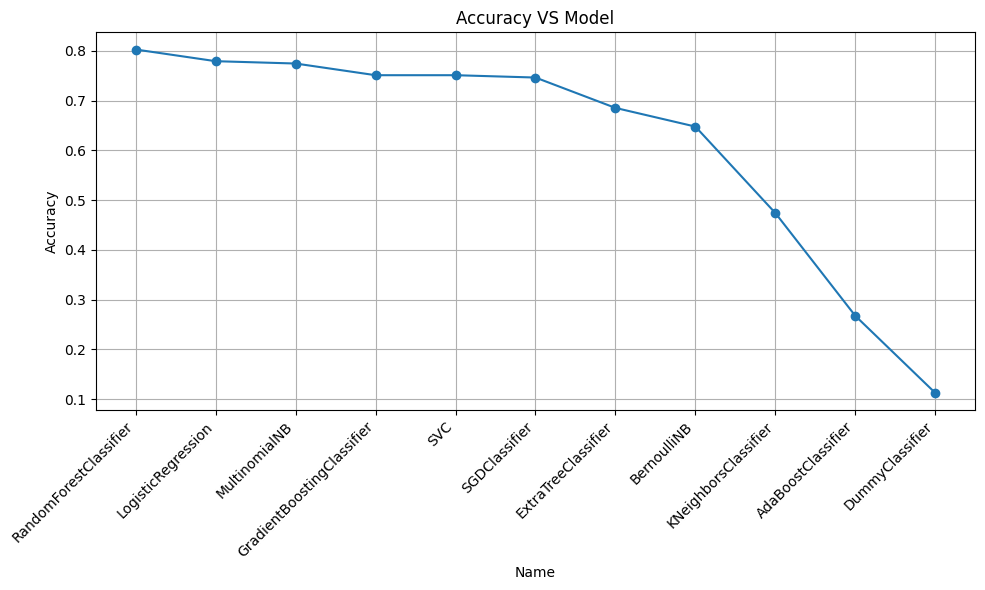

In [19]:
import matplotlib.pyplot as plt

model_df.sort_values(by='Accuracy', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
plt.plot(model_df['Name'], model_df['Accuracy'], marker='o', linestyle='-')
plt.title('Accuracy VS Model')
plt.xlabel('Name')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')  # rotate x labels for readability
plt.grid(True)
plt.tight_layout()
plt.show()

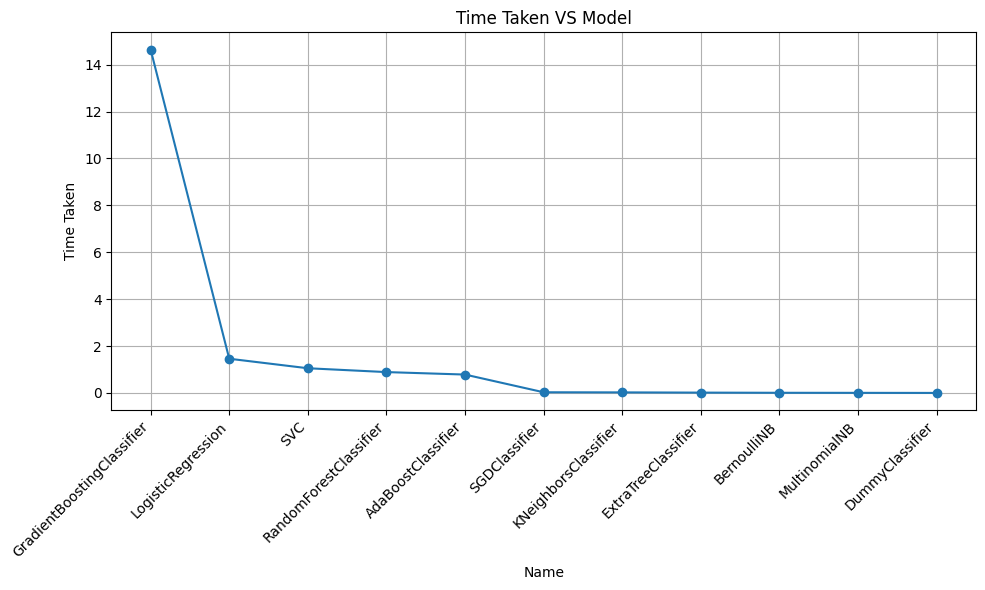

In [20]:
import matplotlib.pyplot as plt

model_df.sort_values(by='Time Taken', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
plt.plot(model_df['Name'], model_df['Time Taken'], marker='o', linestyle='-')
plt.title('Time Taken VS Model')
plt.xlabel('Name')
plt.ylabel('Time Taken')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
best_model_name = model_df.sort_values(by='Accuracy', ascending=False).iloc[0]['Name']
print(f"Best Model: {best_model_name}")
# Create a dictionary mapping model names to model instances
model_dict = {type(model).__name__: model for model in models}

# Instantiate the best model again
best_model = model_dict[best_model_name]

# Train on the full training data
best_model.fit(X_train, y_train)

Best Model: RandomForestClassifier


RandomForestClassifier()

Test Accuracy: 0.8075
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85        42
           1       0.53      0.58      0.55        31
           2       0.91      0.97      0.94        30
           3       0.96      0.71      0.82        35
           4       0.59      0.92      0.72        24
           5       0.93      0.96      0.94        26
           6       0.85      0.88      0.86        25

    accuracy                           0.81       213
   macro avg       0.82      0.82      0.81       213
weighted avg       0.84      0.81      0.81       213



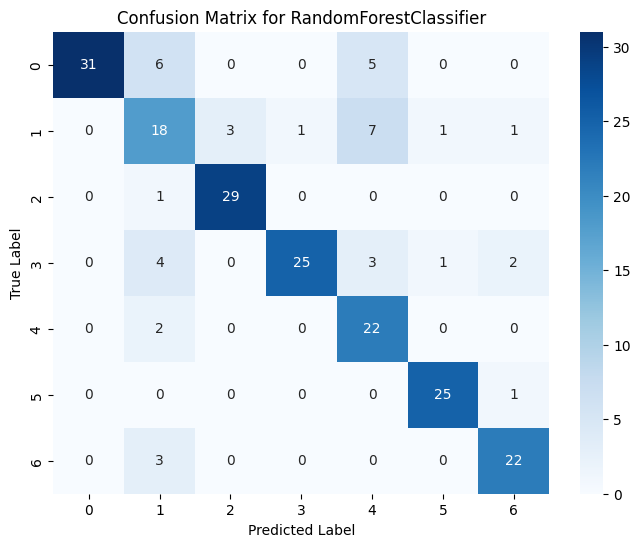

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict test data
y_pred = best_model.predict(X_test)

# Basic accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report (precision, recall, f1 for each class)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()